# Beginner's guide to starwave

So what is it that are we trying to do here?  Basically, trying to fit models to data, accounting for many of the ways that the data gets mucked up.  More specifically, we are trying to infer the physical parameters of stellar clusters by applying/selecting various values of those phyiscal parameters to baseline models and seeing if the output fluxes/distributions match the measured fluxes/distributions.  Some of the parameters we are trying to "fit" include the age, metallicity, and initial mass function of the cluster.

In short, we try different combinations of values for these parameters and simulate a color magnitude using them, and then see how that color magnitude diagram compares to the CMD of the data iteself, and try to tweak the guesses of the parameters to make the two match.  Problems like this are often approached with Monte Carlo methods (Markov Chain Monte Carlos or MCMC), but those methods are computationally expensive.  Instead of doing that, we use simulation based inference (SBI) which uses neural networks to try to estimate the similarity of the simulated data to the measured data (https://sbi-dev.github.io/sbi/).

I have to do the imports like this or the notebook crashes?

In [1]:
from sbi import utils

In [2]:
import torch

In [3]:
import re
import os
from astropy.table import Table, vstack
import tqdm
import glob

import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

import corner
from sbi.analysis import pairplot

In [4]:
# import bz2

In [5]:
# pip install dill

In [ ]:
sys.path.append('/Users/vbajaj/Documents/m22/starwave/')
isochrone_paths = sorted(glob.glob('/Users/vbajaj/Downloads/m22_basti_models/F*/*.isc_wfc3'))
asdf = load_ks2_ascat('/Users/vbajaj/Downloads/LOGA.XYVIQ3.out.sort_art1_art2')
data = Table.read('/Users/vbajaj/Downloads/LOGR.XYVIQ3_dxdy_m22_CRNL', format='ascii.commented_header')

In [7]:


import starwave

# import numpy as np
# import matplotlib.pyplot as plt
# import bz2
# import pandas as pd
# from matplotlib.colors import LogNorm
# import torch
# from sbi import utils


# plt.style.use('vedant')

## Notebook info

This notebook mainly consists of two parts: Loading the various inputs needed for starwave to run, and then running starwave and looking at the results.  Most of the code for the loading of the inputs should be able to run as is.  For running starwave, you will probably end up changing parameters a bit.

### Loading inputs

The inputs for starwave consist of a few different dataframes.
- The isochrones (models of stellar fluxes at a given age) with corresponding metalicity, temperature, mass
- The artificial star photometry (both input and output fluxes)
- The data (photometry of the real stars in the image)
- (Optional) Star formation history grid (not used in this case as we fit the star formation history distribution parameters)

### Load Isochrones

In [9]:
# This function just loads the individual isochrones into tables
def parse_basti_iso(iso_file, physical_columns=['M/Mo(ini)', 'log(L/Lo)', 'logTe'], filters=['F110W', 'F160W']):
    iso_tbl = Table.read(iso_file, format='ascii.commented_header', header_start=6)
    header = iso_tbl.meta['comments']
    for ln in header:
        if 'Age (Myr)' in ln:
            pattern = r'Age \(Myr\) = (\d+\.\d+)'
            match = re.search(pattern, ln)
            iso_tbl.meta['Age'] = float(match.group(1))
            break
    apath = os.path.abspath(iso_file)
    folname = os.path.split(apath)[0].split('/')[-1]
    feh = -1 * float(folname.replace('FEHm', ''))/100. # This should be double checked if [Fe/H] > -1.
    iso_tbl['[Fe/H]'] = feh
    iso_tbl['age'] = iso_tbl.meta['Age']/1000.
    cols = [col for col in ['[Fe/H]', 'age']+physical_columns+filters]
    iso_tbl = iso_tbl[cols]
    if 'M/Mo(ini)' in iso_tbl.colnames:
        iso_tbl.rename_column('M/Mo(ini)', 'mass')
    if 'log(L/Lo)' in iso_tbl.colnames:
        iso_tbl.rename_column('log(L/Lo)', 'logL/Lo')
    return iso_tbl

# This one takes all the individual isochrones and makes one big dataframe as required by starwave
def make_basti_isodf(iso_paths, physical_columns=['M/Mo(ini)', 'log(L/Lo)', 'logTe'], filters=['F110W', 'F160W']):
    tbls = []
    for iso_file in tqdm.tqdm(iso_paths):
        iso_tbl = parse_basti_iso(iso_file, physical_columns=physical_columns, filters=filters)
        tbls.append(iso_tbl)
    stacked_tbl = vstack(tbls, metadata_conflicts='silent')
    
    return stacked_tbl.to_pandas().set_index(['[Fe/H]', 'age', 'mass'])


In [10]:
# each metallicity track must be in its own folder
isodf = make_basti_isodf(isochrone_paths)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 403/403 [00:04<00:00, 94.70it/s]


In [11]:
isodf

logL/Lo    logTe    F110W   F160W
[Fe/H] age  mass                                       
-1.25  10.0 0.100000 -3.03196  3.47117  10.6738  9.9824
            0.102037 -2.99796  3.47573  10.5986  9.9058
            0.104074 -2.96463  3.48020  10.5246  9.8311
            0.106111 -2.93194  3.48459  10.4519  9.7582
            0.108148 -2.89987  3.48889  10.3802  9.6868
...                       ...      ...      ...     ...
-1.85  13.0 0.790003  2.84787  3.65672  -3.6633 -4.3600
            0.790004  2.86500  3.65566  -3.7094 -4.4090
            0.790005  2.88250  3.65455  -3.7564 -4.4593
            0.790006  2.90011  3.65337  -3.8037 -4.5102
            0.790007  2.91841  3.65206  -3.8530 -4.5636

[846300 rows x 4 columns]

In the above dataframe, we are really listing **absolute** magnitudes in two filters as a function of some input physical parameters: Fe/H (metallicity), age (in gigayears), mass (in solar masses).  The logL/Lo represents the log10 of the luminosity divided by solar luminosity, and LogTe is the log10 of the effective temperature.  I believe these two values aren't really used by the simulations, but I'm not sure.

Keep in mind, these are absolute magnitudes, so they don't factor in things like how the distance to the cluster will affect the measured flux, or how any reddening/extinction would affect the flux.  Those are parameters that are inputs to starwave and are applied when it simulates the CMD.

Think of this as just a reference grid that says star with this age, mass, and metallicity come out with this absolute mag, and starwave will apply the corrections needed to measure that magnitude in the simulations

### Load Artifical Stars
This next bit is for loading the artificial stars that were inserted/recovered by KS2.

In [12]:

def load_ks2_ascat(asfile):
    tbl = Table.read(asfile, format='ascii.commented_header')
    dx = tbl['Xo'] - tbl['Xi']
    dy = tbl['Yo'] - tbl['Yi']
    dj = tbl['Jo'] - tbl['Ji']
    dh = tbl['Ho'] - tbl['Hi']
    
    # When using artificial star tests, you have to come up with some criterion that says an artificial star
    # was or was not detected.  In this case, we are saying that a star is a non detection if either the 
    # output position was more than 0.75 pixels away in x or y from the input position, or if any of the output 
    # magnitudes were more than 0.5 mag away from the input magnitude
    fail_mask = (np.abs(dx)>.75) | (np.abs(dy)>.75) | (np.abs(dj)>.5) | (np.abs(dh)>.5)
    
    print(np.sum(fail_mask))
    # Mark the non detections as False in the AS_det column
    tbl['AS_det'] = True
    tbl['AS_det'][fail_mask] = False
    names = ['F110W_in', 'F110W_out', 'F160W_in', 'F160W_out', 'AS_det']
    
    as_tbl = Table([tbl['Ji'], tbl['Jo'], tbl['Hi'], tbl['Ho'], tbl['AS_det']], names=names)
    as_tbl['F110W_out'][~as_tbl['AS_det']] = np.nan
    as_tbl['F160W_out'][~as_tbl['AS_det']] = np.nan
    return as_tbl.to_pandas()
    

In [16]:
asdf

,F110W_in,F110W_out,F160W_in,F160W_out,AS_det
0,13.1200,13.120601,12.4774,12.477388,True
1,13.1380,13.137655,12.9352,12.935116,True
2,13.1400,13.139733,12.4962,12.496099,True
3,13.1430,13.143159,12.5021,12.502469,True
4,13.1610,13.160387,12.9654,12.965309,True
...,...,...,...,...,...
174929,23.3345,23.384732,22.5484,22.575146,True
174930,23.3346,23.333404,22.5538,22.535919,True
174931,23.3377,23.338416,22.5525,22.592847,True
174932,23.3377,23.215393,22.5526,22.557513,True


Let's look at the artificial star input CMD.  In the simple case, this would be a line (a single perfect sequence of stars).  As M22 is thought to have some metallicity spread, there is some width in the CMD, notably in the fainter region.

Text(0, 0.5, '$F160W$')

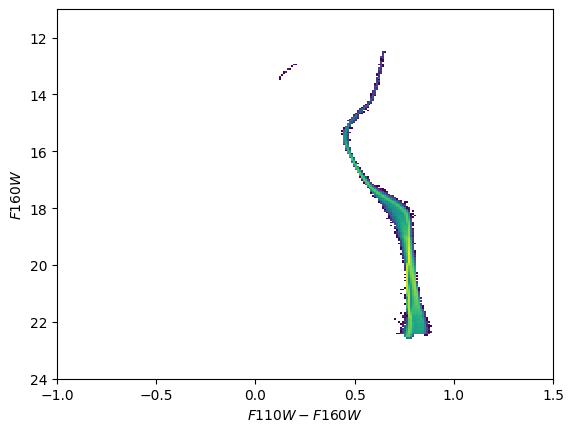

In [17]:
plt.hist2d(asdf['F110W_in'] - asdf['F160W_in'], asdf['F160W_in'],
          bins = 250, norm = LogNorm(),
          range = ((-1, 1.5), (11, 24)));

plt.gca().invert_yaxis()
plt.xlabel('$F110W - F160W$')
plt.ylabel('$F160W$')

Now let's look at the artificial star output CMD.  The point of this is to understand the errors and systematic issues with the detections/recovered fluxes.  Basically, if this does anything super weird (aside from the broadening near the bottom of the CMD, which is mostly just photometric error), then it's probably worth thinking about how that might affect the detection rate.

Text(0, 0.5, '$F160W$')

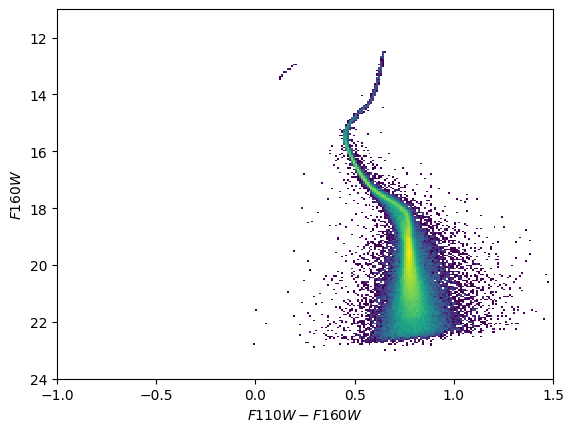

In [18]:
plt.hist2d(asdf['F110W_out'] - asdf['F160W_out'], asdf['F160W_out'],
          bins = 250, norm = LogNorm(),
          range = ((-1, 1.5), (11, 24)));

plt.gca().invert_yaxis()
plt.xlabel('$F110W - F160W$')
plt.ylabel('$F160W$')

### Load SFH Grid
Ignore this bit unless someone gives you an SFH grid

In [19]:
# with bz2.BZ2File(f'{lmc_path}/SFH_2d_frommarginals_metalbound.pbz2') as f:
#     sfh_grid = pd.read_pickle(f)

In [20]:
# sfh_grid

## Loading the measured data

In [21]:

# data = data[data['J']<50]
# data = data[data['H']<50]
data = data[data['H']<23.]  # cut to match AST
data = data[data['J']<23.7]  # cut to match AST
data.rename_column('J', 'F110W')
data.rename_column('H', 'F160W')
data = data.to_pandas()

In [22]:
data

,ID,X,Y,F110W,dJ,QJ,OJ,F160W,dH,QH,OH
0,8,96.24,95.96,13.2809,0.0388,0.999,0.0012,13.1077,0.0063,1.000,0.0028
1,74,17.87,24.65,19.9835,0.0060,1.000,0.7547,19.1725,0.0109,1.000,1.4712
2,79,21.65,131.16,18.6723,0.0087,1.000,0.5178,17.9063,0.0047,1.000,0.8743
3,82,27.77,24.20,19.6971,0.0035,1.000,0.2580,18.9158,0.0025,1.000,0.3135
4,84,30.94,100.66,21.7890,0.0135,0.999,1.8559,21.0724,0.0097,0.999,3.3988
...,...,...,...,...,...,...,...,...,...,...,...
3919,14706,1021.73,1010.24,22.4456,0.0574,0.989,68.2703,21.6890,0.0340,0.980,69.0249
3920,14710,1034.48,983.22,21.2762,0.0278,0.999,1.5857,20.4298,0.0101,1.000,2.2882
3921,14719,1063.76,1002.53,20.9942,0.0224,0.998,3.8281,20.1417,0.0127,1.000,3.1161
3922,14725,990.68,990.81,20.9453,0.0159,1.000,5.6728,20.1581,0.0098,0.999,8.1057


Text(0, 0.5, '$F160W$')

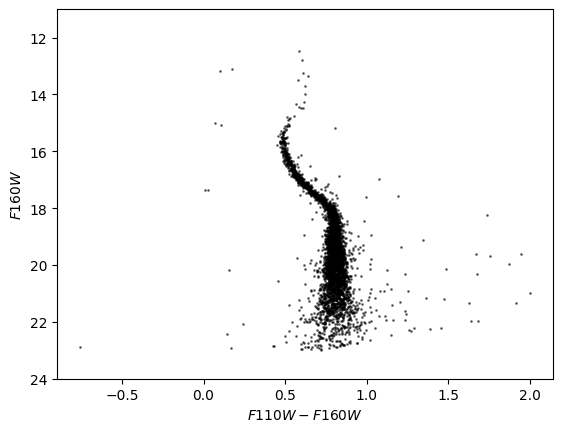

In [23]:
plt.scatter(data['F110W'] - data['F160W'], data['F160W'], s = 1, alpha = 0.5, color = 'k')

plt.ylim(11,24)
plt.gca().invert_yaxis()

plt.xlabel('$F110W - F160W$')
plt.ylabel('$F160W$')

### Setup starwave

In [26]:
print(np.min(isodf.index.get_level_values('age')))
print(np.max(isodf.index.get_level_values('age')))

10.0
13.0


In [ ]:
shortbands = ['F160W', 'F110W']

In [27]:
shortbands

['F160W', 'F110W']

Let's actually set up the starwave object
The inputs are as follows:
* `isodf`: The isochrone dataframe
* `asdf`: artificial star dataframe
* `imf_type`: Initial mass function type (spl, bpl or ln)
* `bands`: The names of each of the bands (must match the names in the dataframes)
* `band_lambdas`: The pivot wavelengths of the bands
* `sfh_type`: star formation history type (gaussian or multigaussian)
* `sfh_ngaussian`: number of gaussians if using multigaussian sfh

See the parameter explanation below for more

In [89]:
# sw = starwave.StarWave(isodf = isodf, asdf = asdf, imf_type = 'bpl',
#                       bands = shortbands, band_lambdas = [15369., 11534.],
#                        sfh_type = 'multigaussian', sfh_ngaussian = 2)

sw = starwave.StarWave(isodf = isodf, asdf = asdf, imf_type = 'bpl',
                      bands = shortbands, band_lambdas = [15369., 11534.],
                       sfh_type = 'gaussian')

interpolating 31 ages and 13 metallicities...


31it [00:01, 21.66it/s]


initalized starwave with ['F160W', 'F110W'] bands, bpl IMF, and default priors
using Rv = 3.1


List all the parameters given the inputs to starwave

In [90]:
sw.params

SWParameters([('log_int',
               SWParameter([('name', 'log_int'),
                            ('value', 2),
                            ('bounds', [2, 6]),
                            ('distribution', 'uniform'),
                            ('dist_kwargs', None),
                            ('fixed', False)])),
              ('bf',
               SWParameter([('name', 'bf'),
                            ('value', 0.2),
                            ('bounds', [0, 1]),
                            ('distribution', 'uniform'),
                            ('dist_kwargs', None),
                            ('fixed', False)])),
              ('dm',
               SWParameter([('name', 'dm'),
                            ('value', 0),
                            ('bounds', [0, 1]),
                            ('distribution', 'uniform'),
                            ('dist_kwargs', None),
                            ('fixed', True)])),
              ('sig_dm',
               SWParameter([

#### Parameter explanation:
**IMF**

IMF types available are single power law (spl), broken power law (bpl) or log normal (ln)
- log_int: Log intercept of distribution
- slope: Power law slope (if using `imf_type='spl'` or `imf_type='ln'`)
- alow: Power law slope for low mass (if using `imf_type='bpl'`)
- ahigh: Power law slope for high mass (if using `imf_type='bpl'`)
- bm: Break mass (if using `imf_type='bpl'` or `imf_type='ln'`)
- mean: mean of log normal distribution (if using `imf_type='ln'`)
- sigma: sigma  of log normal distribution (if using `imf_type='ln'`)
- bf: Binary Fraction

**Distance/extinction**
- av: Av
- dm: Distance modulus
- sig_dm: sigma of distance modulus
- sig_av: sigma of Av (I think this might not actually exist as a parameter?  So differential reddening not supported?)

**SFH params**
Available SFH types are 'gaussian' and 'multigaussian'
If using gaussian:
- age: Age in gyr
- feh: Fe/H
- sig_age: Sigma of age
- sig_feh: Sigma of Fe/H
- age_feh_corr: Covariance of age and Fe/H i think

If using multigaussian with n=2:
- age_0: Age in gyr for population 0
- feh_0: Fe/H for population 0
- sig_age_0: Sigma of age for population 0
- sig_feh_0: Sigma of Fe/H for population 0
- age_feh_corr_0: Covariance of age and Fe/H i think for population 0


In [118]:
logint = 3.9
slope = -1

sw.params['dm'].set(value = 12.52, fixed = True, bounds = [12, 13])
sw.params['log_int'].set(value = logint, bounds = (logint - .5, logint + .5))
sw.params['bf'].set(value = 0.15, fixed = True)
# sw.params['bf'].set(value = 0.4, bounds=(.1, .7), fixed=False)

# sw.params['slope'].set(value = slope, bounds = (-2, 1))
sw.params['alow'].set(value = 0.8, bounds = (-2, 1))
# sw.params['ahigh'].set(value = -3, bounds = (-4, 1))
sw.params['ahigh'].set(value = -2.3, bounds = (-4, 1), fixed=False)
sw.params['bm'].set(value = 0.4, bounds = (.1, .8))

sw.params['av'].set(value = 3.1 * 0.39, bounds = (.5, 1.5), fixed = True)
#sw.params['av'].set(value = 0 * 0.075, bounds = (0, 1), fixed = True)

In [119]:
# sw.params['sig_age_0'].set(value = 0.05, fixed = True)
# sw.params['sig_feh_0'].set(value = 0.05, fixed = True)

# sw.params['age_feh_corr_0'].set(value = 0, fixed = True)

# sw.params['age_0'].set(bounds = [10, 13], value = 11.4, fixed = False)
# sw.params['feh_0'].set(bounds = [-1.85, -1.25], value = -1.67, fixed = True)
# sw.params['population_frac_0'].set(bounds = [0., 1.], value = 0.5, fixed = False)

# sw.params['sig_age_1'].set(value = 0.05, fixed = True)
# sw.params['sig_feh_1'].set(value = 0.07, fixed = True)

# sw.params['age_feh_corr_1'].set(value = 0., fixed = True)

# sw.params['age_1'].set(bounds = [10., 13.], value = 11.7, fixed = False)
# sw.params['feh_1'].set(bounds = [-1.85, -1.25], value = -1.82, fixed = True)
# sw.params['population_frac_1'].set(bounds = [0., 1.], value = 0.5, fixed = False)

In [120]:
sw.params['sig_age'].set(value = 0.3, fixed = True)
sw.params['sig_feh'].set(value = 0.15, fixed = True)

sw.params['age_feh_corr'].set(value = 0, fixed = True)

sw.params['age'].set(bounds = [10, 13], value = 11.4, fixed = True)
sw.params['feh'].set(bounds = [-1.85, -1.25], value = -1.62, fixed = True)

In [121]:
sw.make_prior(sw.params)

[Uniform(low: tensor([3.4000]), high: tensor([4.4000])),
 Uniform(low: tensor([-2.]), high: tensor([1.])),
 Uniform(low: tensor([-4.]), high: tensor([1.])),
 Uniform(low: tensor([0.1000]), high: tensor([0.8000]))]

In [101]:
sw.param_mapper

{'log_int': 0, 'alow': 1, 'bm': 2, 'age': 3}

intNN warning: age out of bounds


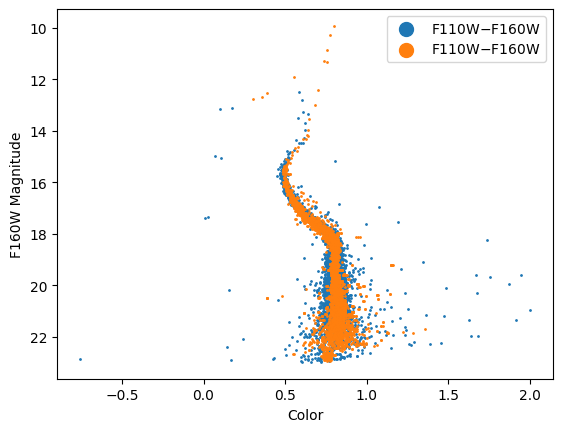

In [102]:
# Plot LMC and sampled CMD

mags = np.vstack((data[shortbands[0]], data[shortbands[1]])).T
#lmc_mags += exts # extinction correction
cmd = sw.make_cmd(mags)

# params = torch.tensor([logint, -.75, .4, 11.4, .5, 11.1, .5])
params = torch.tensor([logint, -.75, .4, 11.1])
eg_cmd = sw.sample_cmd(params, model = 'bpl')[1]


# RESET 
#lmc_cmd = eg_cmd.copy()

starwave.plot_cmd(cmd, bands = shortbands)
starwave.plot_cmd(eg_cmd, bands = shortbands)

plt.gca().invert_yaxis()

### Run Starwave

This is where we run the simulations/bayesian inference.  These parameters are still kind of mysterious, cores=1 is the only value that works now.  n_sims is the number of CMDS that get simulated, should be at least a couple hundred.  n_rounds is the number of neural network trainings/inferences that get done (not really sure what a good value here is).  The others control the network training, but I'm not sure if they matter much.

In [122]:
posteriors = sw.fit_cmd(cmd, cores = 1, n_sims = 350, n_rounds = 4, gamma = None, 
                       gamma_kw = dict(q = 0.68, NN = 5, fac = 1))
# sw = sw.fit_cmd(lmc_cmd, cores = 1, n_sims = 100, n_rounds = 3, gamma = None, 
#                        gamma_kw = dict(q = 0.68, NN = 5, fac = 1))

scaler initialized and mapping defined!
finding optimal kernel width...
setting gamma = 41095
verbose
----------
log_int
----------
Distribution:  uniform
Bounds:  (3.4, 4.4)
Value:  3.9
Fixed:  False
dist_kwargs:  None
----------
bf
----------
Distribution:  uniform
Bounds:  [0, 1]
Value:  0.15
Fixed:  True
dist_kwargs:  None
----------
dm
----------
Distribution:  uniform
Bounds:  [12, 13]
Value:  12.52
Fixed:  True
dist_kwargs:  None
----------
sig_dm
----------
Distribution:  uniform
Bounds:  [0, 0.5]
Value:  0.1
Fixed:  True
dist_kwargs:  None
----------
av
----------
Distribution:  uniform
Bounds:  (0.5, 1.5)
Value:  1.209
Fixed:  True
dist_kwargs:  None
----------
alow
----------
Distribution:  uniform
Bounds:  (-2, 1)
Value:  0.8
Fixed:  False
dist_kwargs:  None
----------
ahigh
----------
Distribution:  uniform
Bounds:  (-4, 1)
Value:  -2.3
Fixed:  False
dist_kwargs:  None
----------
bm
----------
Distribution:  uniform
Bounds:  (0.1, 0.8)
Value:  0.4
Fixed:  False
dist_kwargs

Running 350 simulations.:   0%|          | 0/350 [00:00<?, ?it/s]

Appending
Training
 Neural network successfully converged after 89 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 89
        Best validation performance: -1.4340
        -------------------------
        
Building
Setting
Starting round 2 of neural inference...


Drawing 350 posterior samples:   0%|          | 0/350 [00:00<?, ?it/s]

Running 350 simulations.:   0%|          | 0/350 [00:00<?, ?it/s]

Appending
Training
Using SNPE-C with non-atomic loss
 Neural network successfully converged after 81 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 81
        Best validation performance: -2.2333
        -------------------------
        
Building
Setting
Starting round 3 of neural inference...


Drawing 350 posterior samples:   0%|          | 0/350 [00:00<?, ?it/s]

Running 350 simulations.:   0%|          | 0/350 [00:00<?, ?it/s]

Appending
Training
Using SNPE-C with non-atomic loss
 Neural network successfully converged after 75 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 75
        Best validation performance: -2.4192
        -------------------------
        
Building
Setting
Starting round 4 of neural inference...


Drawing 350 posterior samples:   0%|          | 0/350 [00:00<?, ?it/s]

Running 350 simulations.:   0%|          | 0/350 [00:00<?, ?it/s]

Appending
Training
Using SNPE-C with non-atomic loss
 Neural network successfully converged after 139 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 139
        Best validation performance: -0.8462
        -------------------------
        
Building
Setting


Let's get the last set of values for the posteriors and then draw samples

In [124]:
posteriors = sw.posteriors[-1]

In [126]:
posterior_samples = posteriors.sample((2000000,), x = sw.obs)

Drawing 2000000 posterior samples:   0%|          | 0/2000000 [00:00<?, ?it/s]

In [131]:
sw.param_mapper.keys()

dict_keys(['log_int', 'alow', 'ahigh', 'bm'])

Show the distributions and correlations of the samples

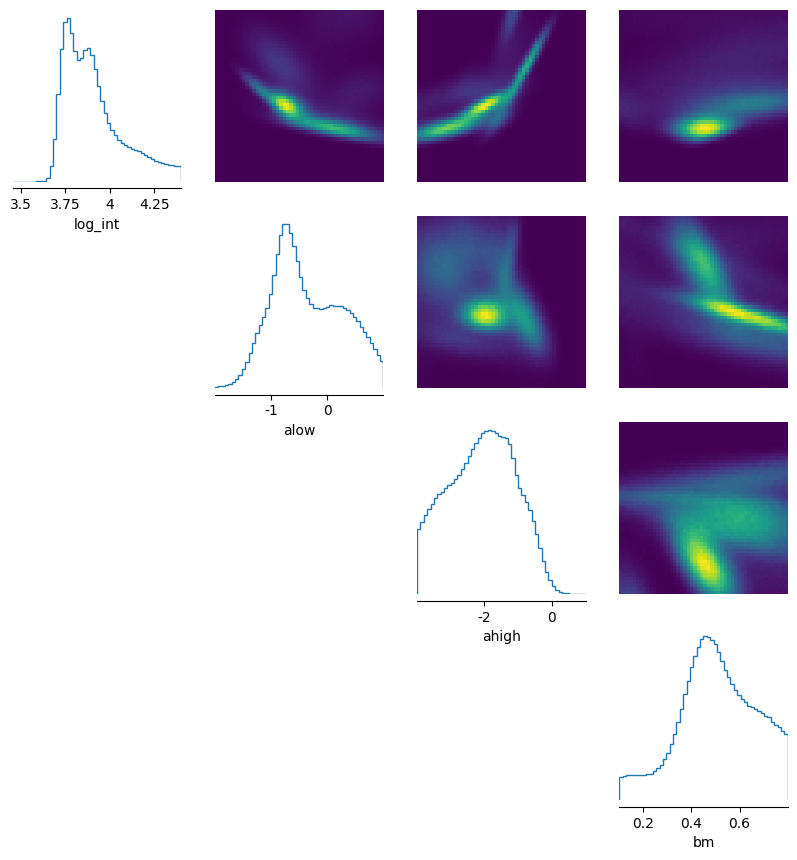

In [132]:
_ = pairplot(posterior_samples, 
                   fig_size=(10,10), labels=list(sw.param_mapper.keys()))

In [135]:
sw.param_mapper

{'log_int': 0, 'alow': 1, 'ahigh': 2, 'bm': 3}

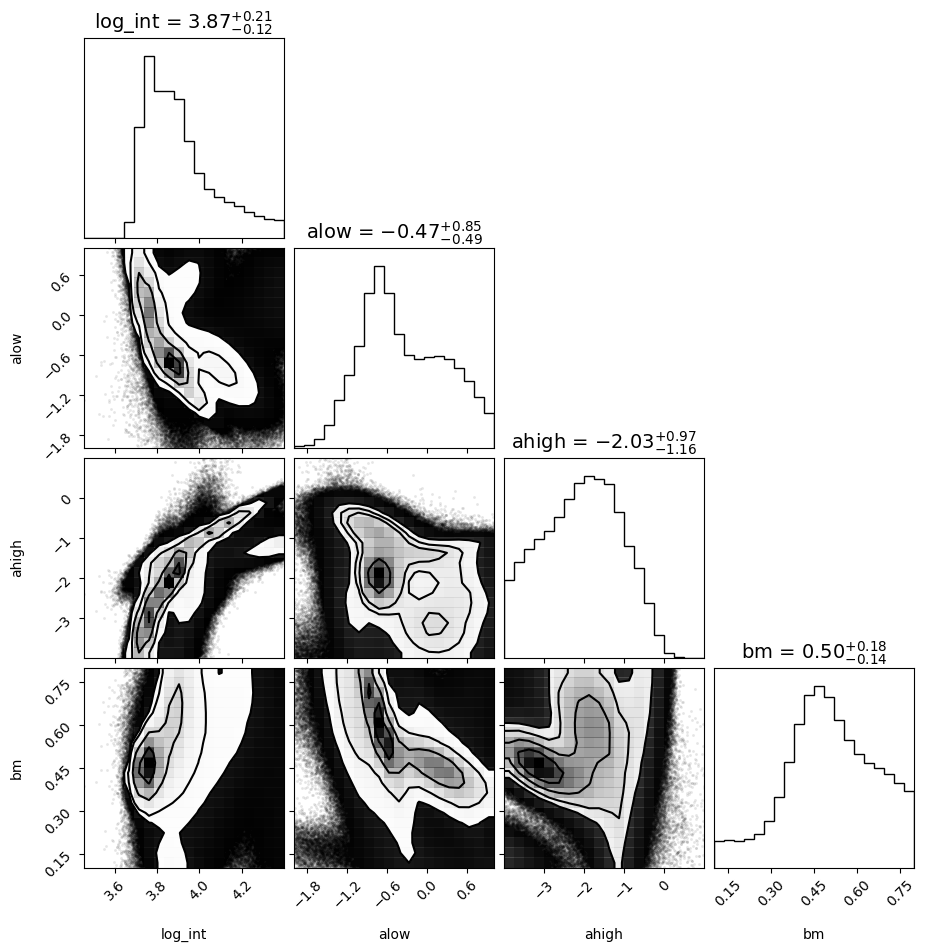

In [136]:
f = corner.corner(np.array(posterior_samples), show_titles = True, 
                  labels = list(sw.param_mapper.keys()), title_kwargs = dict(fontsize = 14))
#                  truths = [logint, slope])